In [1]:
#Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

**a. Visualization, Preprocessing, and Splitting**

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

#Getting and loading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "drive/MyDrive/potatoleaves/potato_ds",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
#Getting the class names
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

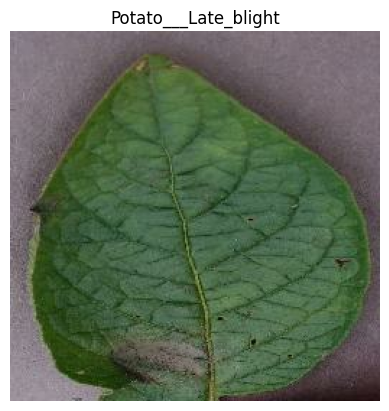

In [ ]:
#Viewing one of the images
for image_batch, label_batch in dataset.take(1):
  plt.imshow(image_batch[0].numpy().astype("uint8"))
  plt.title(classes[label_batch[0]])
  plt.axis("off")

In [5]:
#Getting the train size for the dataset
train_size = 0.8
len(dataset) * train_size

37.6

In [6]:
#Defining a function to split the dataset in tf
def splitting_dataset_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = splitting_dataset_tf(dataset)

In [8]:
len(val_ds)

4

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
# Preprocessing the images (normalization and data augmentation)
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Method 2: Data augmentation for training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

**Reason for selection of different pre-trained models**

The VGG16, ResNet50, and the InceptionV3 pre-trained models are selected for the following reasons:

1. **VGG16:** It is known for its simplicity and effectiveness in image classification tasks. Its architecture consists of multiple convolutional layers, making it suitable for extracting features from images of varying complexities.

2. **ResNet50:** It uses residual connections, which help in training deeper networks without the vanishing gradient problem. It is effective for image classification for example in plant disease detection.

3. **InceptionV3:** It is designed to handle different scales of features within the same layer, making it robust for complex image datasets. It is suitable for detecting subtle differences in plant health.

**b. Model Training**

In [11]:
#Importing the pre-trained models
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

1. **VGG16**

In [12]:
# Pre-trained model, VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
# Selected layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# model
model = Model(inputs=base_model.input, outputs=predictions)

In [14]:
# Freezing the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
history = model.fit(
    train_ds,
    epochs = 2,
    validation_data = val_ds,
    verbose = 1,
)

Epoch 1/2
37/37 ━━━━━━━━━━━━━━━━━━━━ 1177s 25s/step - accuracy: 0.5009 - loss: 0.9680 - val_accuracy: 0.9062 - val_loss: 0.4523
Epoch 2/2
37/37 ━━━━━━━━━━━━━━━━━━━━ 972s 25s/step - accuracy: 0.8395 - loss: 0.4560 - val_accuracy: 0.9219 - val_loss: 0.2964


2. **ResNet50**

In [20]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Selected layers for fine-tuning
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# model
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions)

# Freezing the base model layers
for layer in base_model_resnet.layers:
    layer.trainable = False

# Compiling the model
model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_resnet.fit(
    train_ds,
    epochs = 10,
    validation_data = val_ds,
    verbose = 1,
)

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 315s 8s/step - accuracy: 0.3311 - loss: 1.9029 - val_accuracy: 0.3281 - val_loss: 1.1156
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 323s 9s/step - accuracy: 0.4141 - loss: 1.1194 - val_accuracy: 0.6016 - val_loss: 0.9452
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 365s 8s/step - accuracy: 0.4617 - loss: 1.0203 - val_accuracy: 0.5156 - val_loss: 0.9341
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 321s 8s/step - accuracy: 0.5525 - loss: 0.9209 - val_accuracy: 0.6094 - val_loss: 0.8684
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 320s 8s/step - accuracy: 0.5773 - loss: 0.8993 - val_accuracy: 0.7109 - val_loss: 0.8206
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 320s 8s/step - accuracy: 0.5588 - loss: 0.8792 - val_accuracy: 0.6562 - val_loss: 0.7981
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 328s 8s/step - accuracy: 0.5932 - loss: 0.8528 - val_accuracy: 0.6797 - val_loss: 0.7735
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 323s 8s/step - accuracy: 0.6051 - loss: 0.8507 - val_accuracy: 0.6406 - v

3. **InceptionV3**

In [21]:
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Selected layers for fine-tuning
x = base_model_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

# model
model_inception = Model(inputs=base_model_inception.input, outputs=predictions)

# Freezing the base model layers
for layer in base_model_inception.layers:
    layer.trainable = False

# Compiling the model
model_inception.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_inception.fit(
    train_ds,
    epochs = 4,
    validation_data = val_ds,
    verbose = 1,
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/4
37/37 ━━━━━━━━━━━━━━━━━━━━ 209s 5s/step - accuracy: 0.6191 - loss: 1.4260 - val_accuracy: 0.9531 - val_loss: 0.1787
Epoch 2/4
37/37 ━━━━━━━━━━━━━━━━━━━━ 219s 6s/step - accuracy: 0.8705 - loss: 0.3251 - val_accuracy: 0.9688 - val_loss: 0.1449
Epoch 3/4
37/37 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.9341 - loss: 0.1830 - val_accuracy: 0.9609 - val_loss: 0.1302
Epoch 4/4
37/37 ━━━━━━━━━━━━━━━━━━━━ 203s 5s/step - accuracy: 0.9395 - loss: 0.1519 - val_accuracy: 0.9844 - val_loss: 0.0822


**c. Model Evaluation**

*   VGG16
*   ResNet50
*   InceptionNet







In [23]:
# Evaluating the VGG16
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy VGG16 Model: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 149s 23s/step - accuracy: 0.9170 - loss: 0.3230
Test Accuracy VGG16 Model: 0.9167, Test Loss: 0.3138


In [24]:
# Evaluating the ResNet50
test_loss, test_accuracy = model_resnet.evaluate(test_ds)
print(f"Test Accuracy VGG16 Model: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 8s/step - accuracy: 0.6877 - loss: 0.7546
Test Accuracy VGG16 Model: 0.6979, Test Loss: 0.7447


In [25]:
# Evaluating the InceptionV3
test_loss, test_accuracy = model_inception.evaluate(test_ds)
print(f"Test Accuracy VGG16 Model: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 5s/step - accuracy: 0.9813 - loss: 0.0689
Test Accuracy VGG16 Model: 0.9740, Test Loss: 0.0828


**d. Detailed Performance Metrics**

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np



*  **Vgg16**


In [27]:
# Prediction on test data using VGG16 model
test_preds = model.predict(test_ds)
test_preds = np.argmax(test_preds, axis=1)

true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# report for VGG16
print(classification_report(true_labels, test_preds, target_names=classes))

6/6 ━━━━━━━━━━━━━━━━━━━━ 140s 23s/step
                       precision    recall  f1-score   support

Potato___Early_blight       0.36      0.37      0.37        67
 Potato___Late_blight       0.36      0.31      0.33        65
     Potato___healthy       0.31      0.35      0.33        60

             accuracy                           0.34       192
            macro avg       0.34      0.34      0.34       192
         weighted avg       0.35      0.34      0.34       192





*   **ResNet50**


In [28]:
# Prediction on test data using ResNet50 model
test_preds = model_resnet.predict(test_ds)
test_preds = np.argmax(test_preds, axis=1)

true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# report for ResNet50
print(classification_report(true_labels, test_preds, target_names=classes))

6/6 ━━━━━━━━━━━━━━━━━━━━ 54s 9s/step
                       precision    recall  f1-score   support

Potato___Early_blight       0.40      0.31      0.35        67
 Potato___Late_blight       0.34      0.38      0.36        65
     Potato___healthy       0.31      0.33      0.32        60

             accuracy                           0.34       192
            macro avg       0.35      0.34      0.34       192
         weighted avg       0.35      0.34      0.34       192





*   **InceptionV3**



In [29]:
# Prediction on test data using InceptionV3 model
test_preds = model_inception.predict(test_ds)
test_preds = np.argmax(test_preds, axis=1)

true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# report for InceptionV3
print(classification_report(true_labels, test_preds, target_names=classes))

6/6 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step
                       precision    recall  f1-score   support

Potato___Early_blight       0.38      0.39      0.39        67
 Potato___Late_blight       0.35      0.37      0.36        65
     Potato___healthy       0.32      0.30      0.31        60

             accuracy                           0.35       192
            macro avg       0.35      0.35      0.35       192
         weighted avg       0.35      0.35      0.35       192

